# Healthcare/Stroke Dataset Classifier Analysis

This notebook consists of analysis of the best binary classifier for the stroke dataset. I will explore many different models and provide my analysis for each, making an overall conclusion about the best model.

I will just use the `scikit-learn` library to train the models and obtain predictions. Ideally, I'd use some custom classes to obtain more helpful diagnostics for each model, but I want to keep things simple given how many different classification models will be implemented. While a black box, `scikit-learn` does produce similar results as the algorithms presented in class and in our own repositories.

**Feature Sets Analyzed:**
1. Full 10 features
2. 3 features (age, avg_glucose_level, bmi) following feature selection

**Classification Models Analyzed:**
1. The Perceptron
2. Logistic Regression
3. Dense Neural Networks (Multilayer Perceptron)
4. *k*-Nearest Neighbors
5. Decision Trees
6. Bagging/Random Forests
7. Voting

In [1]:
## Import necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import classification models
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Import useful functions used to evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.feature_selection import SelectFromModel

# surpress deprecation warnings, such as those from KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore') 

## Data Processing

In [2]:
# Read in the data set
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In class, we found that there were only 201 missing values, all in the `bmi` column. These observations will simply be dropped.

In [3]:
df_cleaned = df.dropna()

Next, note that the `gender`, `ever_married`, `work_type`, `residence_type`, and `smoking_status` variables are categorical. If these variables are to be used in the models, they need to be converted to a numerical scale. Ideally, the non-binary variables should be arranged into an ordinal scale, but it is hard to determine an order these variables such as `work_type`.

In [4]:
df_cleaned.gender = df_cleaned.gender.map({"Male": 0, "Female": 1, "Other": 2})
df_cleaned.ever_married = df_cleaned.ever_married.map({"No": 0, "Yes": 1})
df_cleaned.work_type = df_cleaned.work_type.map({"Private": 0, "Self-employed": 1, "children": 2, "Govt_job": 3, "Never_worked": 4})
df_cleaned.Residence_type = df_cleaned.Residence_type.map({"Rural": 0, "Urban": 1})
df_cleaned.smoking_status = df_cleaned.smoking_status.map({"never smoked": 0, "Unknown": 1, "formerly smoked": 2, "smokes": 3})

In [5]:
df_cleaned = df_cleaned.drop("id", axis = 1)
df_cleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,2,1
2,0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,1,49.0,0,0,1,0,1,171.23,34.4,3,1
4,1,79.0,1,0,1,1,0,174.12,24.0,0,1
5,0,81.0,0,0,1,0,1,186.21,29.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,1,13.0,0,0,0,2,0,103.08,18.6,1,0
5106,1,81.0,0,0,1,1,1,125.20,40.0,0,0
5107,1,35.0,0,0,1,1,0,82.99,30.6,0,0
5108,0,51.0,0,0,1,0,0,166.29,25.6,2,0


This is the cleaned data set that will be split into a training/testing set to find the best binary classifier. I will proceed with all of these variables because analysis of the correlation matrix in class told us that there weren't any pairs of variables with high correlation, it will be interesting to see what happens.

## Training a Binary Classifier

In the next sections, I will be training different classification models to see what the best one is. This will involve analyzing the model's accuracy in predictions. 

For example, the code below (which was the example posted on Canvas) implements a random forest classifier and evaluates the model's accuracy on test data versus just blindly guessing 0 for all predictions.

In [6]:
df_num = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].dropna()
X, y = df_num[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']], df_num['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict with the trained model
y_pred = rf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred) = } \n')

# always predict 0
y_zeros = np.zeros(y_test.shape)
print(f'{accuracy_score(y_test, y_zeros) = }')

accuracy_score(y_test, y_pred) = 0.945010183299389 

accuracy_score(y_test, y_zeros) = 0.9460285132382892


Observe that the accuracy score when making predictions from the model is lower than if you had guessed 0 for all predictions. Consequently, I conclude that this model could do better, and is not the best way to predict occurrence of a stroke given the 5 predictors used to train.

#### Some helpful functions I will be using

The function below plots a confusion matrix, which will be helpful in identifying the number of correct classifications for each class. It also can quickly inform about the type I/II errors.

In [7]:
def plot_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)

Sometimes it can be difficult to determine what model to proceed with based on accuracy (can achieve higher accuracy with more complexity, see Decision Tree section), and examining the bias/variance can help make an informed decision.

In [8]:
def print_bias_variance(model, X_train, y_train, X_test, y_test):
    """
    Print the bias and variance decomposition for a model.
    A model with high bias and low variance may underfit the data, 
    while a model with low bias and high variance may overfit the data.
    """
    mse, bias, var = bias_variance_decomp(
         model, X_train.values, y_train.values, X_test.values, y_test.values, loss = 'mse', random_seed = 123)
    print('MSE: %.3f' % mse) # aka Expected Loss
    print('Bias: %.3f' % bias)
    print('Variance: %.3f' % var)

It would be good to plot decision boundaries for each model, but since the features are multi-dimensional (more than 2-D), it will be hard to visualize meaningfully.

## Model 1: The Perceptron

#### Defining the training set

Analysis of the correlation matrix in class told us that there weren't any pairs of variables with high correlation. I am just going to include all variables (including categorical ones) in `df_cleaned` and see what happens.

The data will be split into a training and testing set using the 80/20 rule of the Pareto principle. This same split will be consistent across all models that will be trained in this notebook, meaning the training observations and testing observations will remain consistent for analysis.

In [9]:
X, y = df_cleaned.loc[:, df_cleaned.columns != "stroke"], df_cleaned['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Recall that the data is unbalanced. It would be a good exercise to ensure that the training data set is representative through visualizations, but I just observe that the training and testing data have similar ratios for 0's vs. 1's and proceed with model training. Besides, I will be implementing ensemble methods, which helps train a better model for classification tasks with unbalanced data.

In [10]:
y_train.value_counts()

0    3771
1     156
Name: stroke, dtype: int64

In [11]:
y_test.value_counts()

0    929
1     53
Name: stroke, dtype: int64

#### Finding the best model under different learning rates

In [12]:
learning_rates = [0.8, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for eta in learning_rates:
    per_model = Perceptron(eta0 = eta, max_iter = 5000, random_state = 42)
    per_model.fit(X_train, y_train)
    print(f"rate = {eta}: {per_model.score(X_train, y_train)}")

rate = 0.8: 0.949834479246244
rate = 0.5: 0.949834479246244
rate = 0.25: 0.949834479246244
rate = 0.1: 0.949834479246244
rate = 0.01: 0.949834479246244
rate = 0.001: 0.949834479246244
rate = 0.0001: 0.949834479246244
rate = 1e-05: 0.949834479246244


#### Performance/Error Analysis

In [13]:
per_model = Perceptron(eta0 = 0.0001, max_iter = 5000, random_state = 42)
per_model.fit(X_train, y_train)

print("Training accuracy:", per_model.score(X_train, y_train))
print("Testing accuracy:", per_model.score(X_test, y_test))

Training accuracy: 0.949834479246244
Testing accuracy: 0.9439918533604889


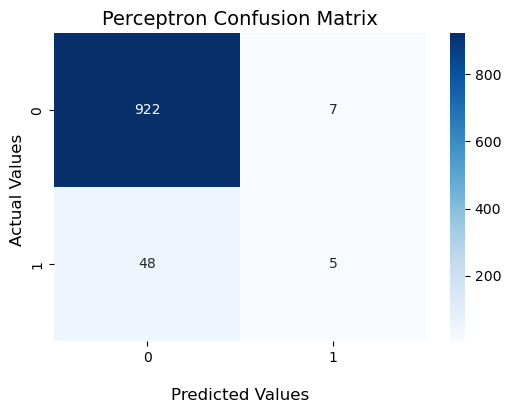

In [14]:
y_pred = per_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Perceptron Confusion Matrix", fontsize = 14)
plt.show()

## Model 2: Logistic Regression

There doesn't appear to be an option to change parameters to train a logistic regression model using scikit-learn, so I'll just move forwards with the default.

#### Performance/Error Analysis

In [15]:
log_model = LogisticRegression(random_state = 42)
log_model.fit(X_train, y_train)
print("Training accuracy:", log_model.score(X_train, y_train))
print("Testing accuracy:", log_model.score(X_test, y_test))

Training accuracy: 0.9605296664120193
Testing accuracy: 0.9460285132382892


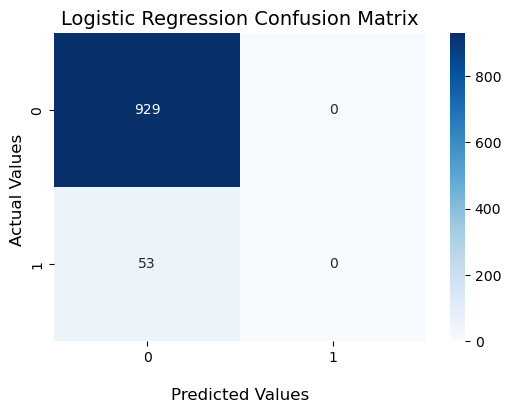

In [16]:
y_pred = log_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression Confusion Matrix", fontsize = 14)
plt.show()

## Model 3: Dense Neural Networks (Multilayer Perceptron)

#### Finding the best model under different learning rates

In [17]:
for lr in learning_rates:
    mlp_model = MLPClassifier(learning_rate_init = lr, max_iter = 500, random_state = 42)
    mlp_model.fit(X_train, y_train)
    print(f"rate = {lr}: {mlp_model.score(X_train, y_train)} with {mlp_model.n_layers_} layers")

rate = 0.8: 0.9602750190985485 with 3 layers
rate = 0.5: 0.9602750190985485 with 3 layers
rate = 0.25: 0.9602750190985485 with 3 layers
rate = 0.1: 0.9602750190985485 with 3 layers
rate = 0.01: 0.9602750190985485 with 3 layers
rate = 0.001: 0.9582378405907818 with 3 layers
rate = 0.0001: 0.959511077158136 with 3 layers
rate = 1e-05: 0.9592564298446652 with 3 layers


In [18]:
mlp_model = MLPClassifier(learning_rate_init = 0.01, max_iter = 500, random_state = 42)
mlp_model.fit(X_train, y_train)

print("Training accuracy:", mlp_model.score(X_train, y_train))
print("Testing accuracy:", mlp_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


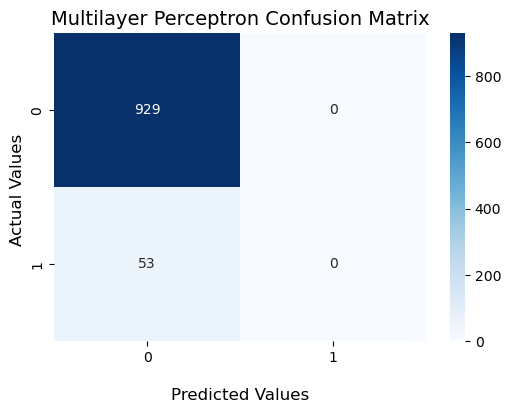

In [19]:
y_pred = mlp_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Multilayer Perceptron Confusion Matrix", fontsize = 14)
plt.show()

## Model 4: *k*-Nearest Neighbors

#### Finding the optimal k

In [20]:
knn_accuracy = []
#possible_k = range(3, int(np.ceil(np.sqrt(X_train.shape[0]))))
possible_k = range(3, 16)
for k in possible_k:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    knn_accuracy.append(knn.score(X_train, y_train))

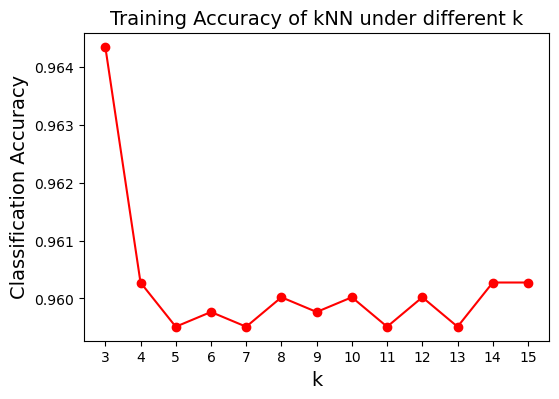

In [21]:
plt.figure(figsize = (6, 4))
plt.plot(possible_k, knn_accuracy, color = 'red', marker = "o")
plt.title("Training Accuracy of kNN under different k", fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_k)
plt.show()

The classification accuracy is highest when k = 3, so that is what I will proceed with.

#### Performance/Error Analysis

In [22]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

Training accuracy: 0.964349376114082
Testing accuracy: 0.9348268839103869


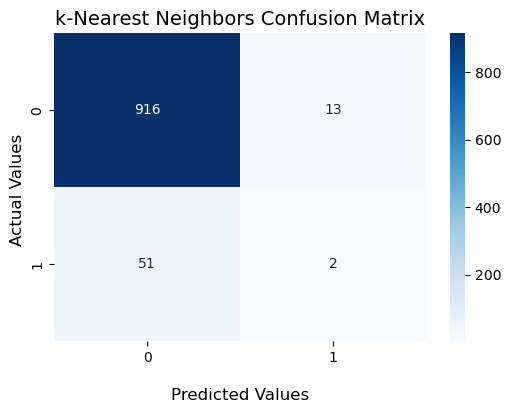

In [23]:
y_pred = knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 14)
plt.show()

## Model 5: Decision Trees

#### Finding the optimal depth

In [24]:
# Obtain the accuracy for a range of depths for plotting
tree_accuracy = []
possible_depth = range(2, 21)
for d in possible_depth:
    tree_model = DecisionTreeClassifier(max_depth = d, random_state = 42)
    tree_model.fit(X_train, y_train)
    tree_accuracy.append(tree_model.score(X_train, y_train))

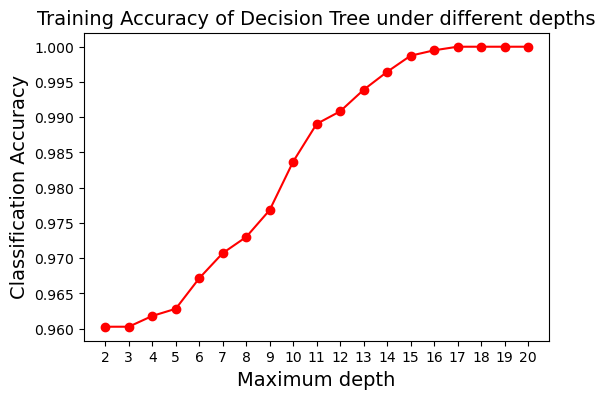

In [25]:
plt.figure(figsize = (6, 4))
plt.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
plt.title("Training Accuracy of Decision Tree under different depths", fontsize = 14)
plt.xlabel('Maximum depth', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_depth)
plt.show()

To maximize accuracy, the maximum depth of the tree should be 17. Anything beyond 17 would be overfitting without a significant gain in accuracy. However, realize that the training accuracy at this point is greater than 99% already. This accuracy is super high; even at `max_depth=11` there is 99% training accuracy and `max_depth=2` has 96% training accuracy as well. I need another metric to evaluate what the best model is, so that I don't pick something that will definitely overfit.

One way to approach this is to note the bias/variance tradeoff. A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data. I want to balance both the bias and variance.

In [26]:
# Obtain the bias/variance for each max_depth Decision Tree for plotting
biases = []
variances = []
for d in possible_depth:
    tree_model = DecisionTreeClassifier(max_depth = d, random_state = 42)
    tree_model.fit(X_train, y_train)
    _, bias, var = bias_variance_decomp(tree_model,
        X_train.values, y_train.values, X_test.values, y_test.values, loss = 'mse', random_seed = 123)
    biases.append(bias)
    variances.append(var)

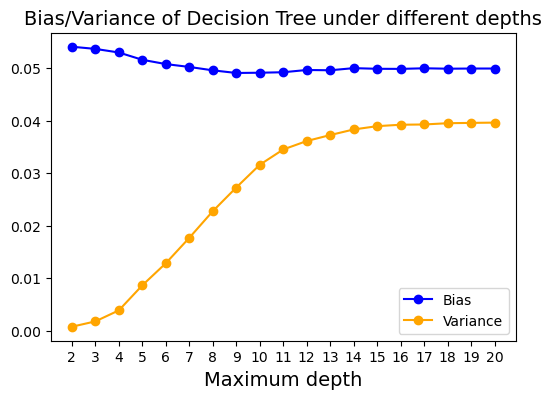

In [27]:
plt.figure(figsize = (6, 4))
plt.plot(possible_depth, biases, color = 'blue', marker = "o", label = "Bias")
plt.plot(possible_depth, variances, color = 'orange', marker = "o", label = "Variance")
plt.title("Bias/Variance of Decision Tree under different depths", fontsize = 14)
plt.xlabel('Maximum depth', fontsize = 14)
plt.xticks(possible_depth)
plt.legend(loc = "lower right")
plt.show()

Bias slightly decreases as the depth increases initially, but then remains mostly consistent. Thus, the focus will be the variance. The variance cannot be too high or there will be overfitting. Examining this plot and the previous accuracy plot, I think I will examine two models. 

The first is a Decision Tree with maximum depth of 11 because beyond this point, an increase in the depth does not increase the classification accuracy by much. Variance is esentially at the highest too, beyond this point there are no significant increases.

The second is a Decision Tree with a maximum depth of 7. I think a depth of 11 might still be too overfit as suggested by the training accuracy of 99%. Furthermore, the variance is at the highest at a depth of 11. I'm curious what happens when I move towards the left of the curve with lower variance and a slightly higher bias.

#### Performance/Error Analysis (max_depth=11)

In [28]:
tree_model11 = DecisionTreeClassifier(max_depth = 11, random_state = 42)
tree_model11.fit(X_train, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", tree_model11.score(X_train, y_train))
print("Testing accuracy:", tree_model11.score(X_test, y_test))

Training accuracy: 0.9890501655207538
Testing accuracy: 0.9215885947046843


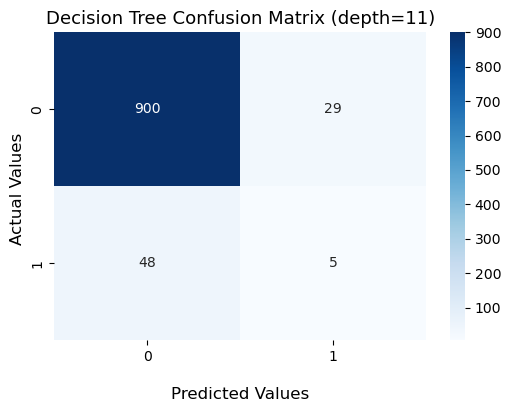

In [29]:
y_pred = tree_model11.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=11)", fontsize = 13)
plt.show()

In [30]:
print_bias_variance(tree_model11, X_train, y_train, X_test, y_test)

MSE: 0.084
Bias: 0.049
Variance: 0.035


#### Performance/Error Analysis (max_depth=7)

In [31]:
tree_model7 = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_model7.fit(X_train, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", tree_model7.score(X_train, y_train))
print("Testing accuracy:", tree_model7.score(X_test, y_test))

Training accuracy: 0.970715558950853
Testing accuracy: 0.9368635437881874


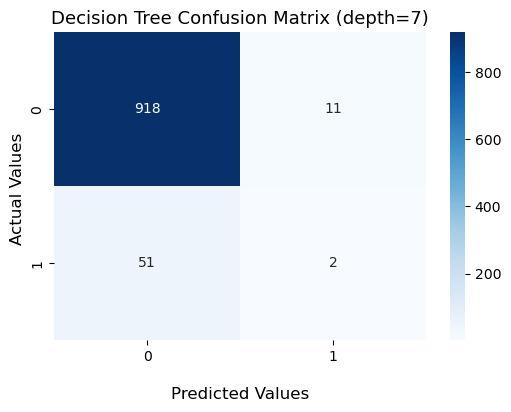

In [32]:
y_pred = tree_model7.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=7)", fontsize = 13)
plt.show()

In [33]:
print_bias_variance(tree_model7, X_train, y_train, X_test, y_test)

MSE: 0.068
Bias: 0.050
Variance: 0.018


#### The Best Decision Tree

A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data.

Between `max_depth=11` and `max_depth=7`, I will argue that `max_depth=7` produces the better model. The bias essentially the same, but the variance for `max_depth=7` is half that for when `max_depth=11`. Furthermore, at `max_depth=11`, the training accuracy is almost 99%, signaling there is truly overfitting - the model fits the training data too well, as shown by how the testing accuracy is lower for `max_depth=11`.

| Metric      | max_depth=11 | max_depth=7 |
| ----------- | ------------ | ----------- |
| Training Accuracy| 98.91% | 97.07% |
| Testing Accuracy | 92.16% | 93.69% |
| Bias             |  0.049 | 0.050 |
| Variance         |  0.035 | 0.018 |

It would be good to explore other `max_depth`s below 11, but I will leave it there.

## Model 6: Bagging/Random Forests

In [34]:
forest_model = RandomForestClassifier(
    max_depth = 7, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model.fit(X_train, y_train)
#forest_y_pred = forest_clf.predict(X_test)
#print(f"Forest Classification Report")
#print(classification_report(y_test, forest_y_pred), "\n")

print("Training accuracy:", forest_model.score(X_train, y_train))
print("Testing accuracy:", forest_model.score(X_test, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.9460285132382892


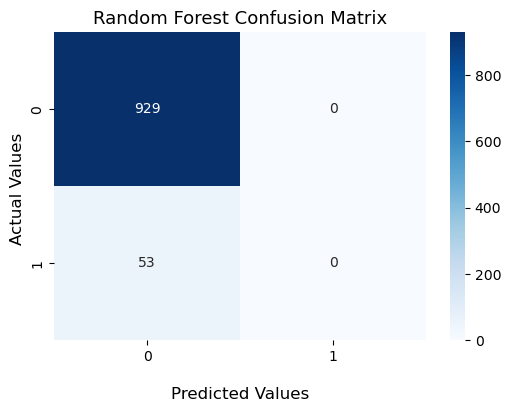

In [35]:
y_pred = forest_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Random Forest Confusion Matrix", fontsize = 13)
plt.show()

## Model 7: Voting

A voting classifier takes a set of estimators/models. Its effectiveness will depend on the diversity of the models (complexity and inherent stability properties) and performance of each model. The best combination/set can be determined with the help of cross-validation, but I will just try two combinations.

#### Voting Model 1: Reducing False Negatives

In [36]:
voting_model = VotingClassifier(estimators=[
    ('per', per_model), ('dt7', tree_model7), ('rf', forest_model)])
voting_model.fit(X_train, y_train)

print("Training accuracy:", voting_model.score(X_train, y_train))
print("Testing accuracy:", voting_model.score(X_test, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.945010183299389


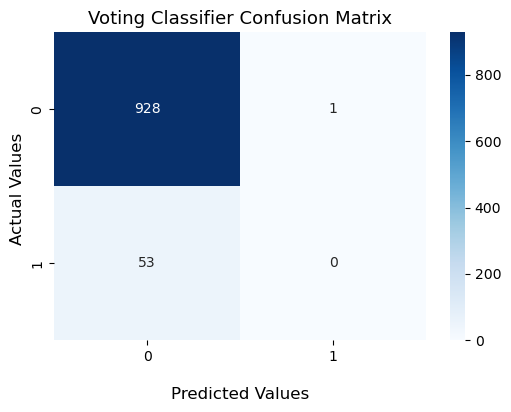

In [37]:
y_pred = voting_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Voting Classifier Confusion Matrix", fontsize = 13)
plt.show()

### Voting Model 2

## Model 8: Boosting

## Feature Selection

Up until now, all of the models involved the full feature set. This may lead to more complex/overfit models overall. Using random forests, the importance of each feature can be calculated. Now, I am going to perform feature selection, subset the dataset to these variables, and then rerun all the previous analysis to see if there will be an improvement in results.

In [38]:
# Output each feature's importance
for ft, imp in zip(X_train.columns, forest_model.feature_importances_):
    print(f"{abs(imp):.3f} - {ft}")

0.026 - gender
0.278 - age
0.037 - hypertension
0.037 - heart_disease
0.021 - ever_married
0.046 - work_type
0.025 - Residence_type
0.291 - avg_glucose_level
0.185 - bmi
0.055 - smoking_status


Only 3 variables have an importance greater than 0.1 - age, avg_glucose_level, and bmi. The `SelectFromModel` function selects only these three variables to be kept.

In [39]:
trimmed_model = SelectFromModel(forest_model, prefit=True)
cols_keep = list(X_train.columns[trimmed_model.get_support()])
cols_drop = list(X_train.columns[~trimmed_model.get_support()])
print("Keeping:", cols_keep)
print("Dropping:", cols_drop)

Keeping: ['age', 'avg_glucose_level', 'bmi']
Dropping: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


Now, I update the X matrices to rerun all the previous models using this lower dimensionality feature set.

In [40]:
#X_train2 = trimmed_model.transform(X_train)
#X_test2 = trimmed_model.transform
X_train2 = X_train.drop(cols_drop, axis = 1)
X_test2 = X_test.drop(cols_drop, axis = 1)

### a) Rerunning the Perceptron

In [41]:
learning_rates = [0.8, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for eta in learning_rates:
    per_model2 = Perceptron(eta0 = eta, max_iter = 5000, random_state = 42)
    per_model2.fit(X_train2, y_train)
    print(f"rate = {eta}: {per_model2.score(X_train2, y_train)}")

rate = 0.8: 0.9582378405907818
rate = 0.5: 0.9582378405907818
rate = 0.25: 0.9582378405907818
rate = 0.1: 0.9582378405907818
rate = 0.01: 0.9582378405907818
rate = 0.001: 0.9582378405907818
rate = 0.0001: 0.9582378405907818
rate = 1e-05: 0.9582378405907818


No learning rate leads to a better model over another, I'll just use 0.0001.

In [42]:
per_model2 = Perceptron(eta0 = 0.0001, max_iter = 5000, random_state = 42)
per_model2.fit(X_train2, y_train)

print("Training accuracy:", per_model2.score(X_train2, y_train))
print("Testing accuracy:", per_model2.score(X_test2, y_test))

Training accuracy: 0.9582378405907818
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the Perceptron model for the full feature set (below), the model does better after performing feature selection!

In [43]:
print("Training accuracy:", per_model.score(X_train, y_train))
print("Testing accuracy:", per_model.score(X_test, y_test))

Training accuracy: 0.949834479246244
Testing accuracy: 0.9439918533604889


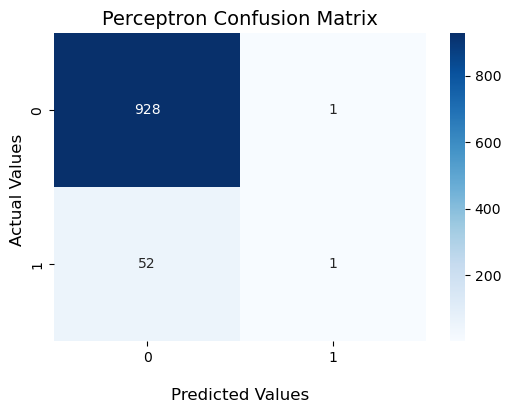

In [44]:
# Confusion matrix for model post feature selection
y_pred = per_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Perceptron Confusion Matrix", fontsize = 14)
plt.show()

### b) Rerunning Logistic Regression

In [45]:
log_model2 = LogisticRegression(random_state = 42)
log_model2.fit(X_train2, y_train)
print("Training accuracy:", log_model2.score(X_train2, y_train))
print("Testing accuracy:", log_model2.score(X_test2, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model has essentially the same accuracy after performing feature selection.

In [46]:
print("Training accuracy:", log_model.score(X_train, y_train))
print("Testing accuracy:", log_model.score(X_test, y_test))

Training accuracy: 0.9605296664120193
Testing accuracy: 0.9460285132382892


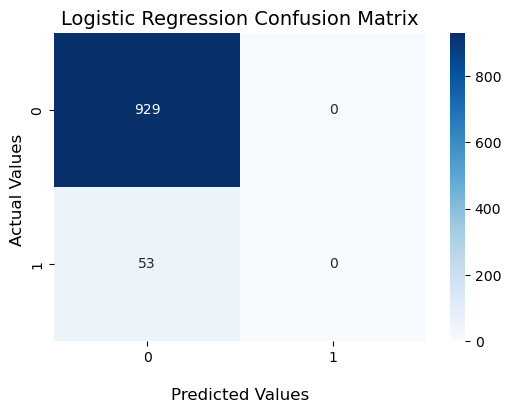

In [47]:
# Confusion matrix for model post feature selection
y_pred = log_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression Confusion Matrix", fontsize = 14)
plt.show()

### c) Rerunning Multilayer Perceptron

In [48]:
for lr in learning_rates:
    mlp_model2 = MLPClassifier(learning_rate_init = lr, max_iter = 500, random_state = 42)
    mlp_model2.fit(X_train2, y_train)
    print(f"rate = {lr}: {mlp_model2.score(X_train2, y_train)} with {mlp_model2.n_layers_} layers")

rate = 0.8: 0.9602750190985485 with 3 layers
rate = 0.5: 0.9602750190985485 with 3 layers
rate = 0.25: 0.9602750190985485 with 3 layers
rate = 0.1: 0.9602750190985485 with 3 layers
rate = 0.01: 0.9602750190985485 with 3 layers
rate = 0.001: 0.9602750190985485 with 3 layers
rate = 0.0001: 0.9600203717850777 with 3 layers
rate = 1e-05: 0.9590017825311943 with 3 layers


In [49]:
mlp_model2 = MLPClassifier(learning_rate_init = 0.01, max_iter = 500, random_state = 42)
mlp_model2.fit(X_train2, y_train)

print("Training accuracy:", mlp_model2.score(X_train2, y_train))
print("Testing accuracy:", mlp_model2.score(X_test2, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model has the same accuracy after performing feature selection.

In [50]:
print("Training accuracy:", mlp_model.score(X_train, y_train))
print("Testing accuracy:", mlp_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


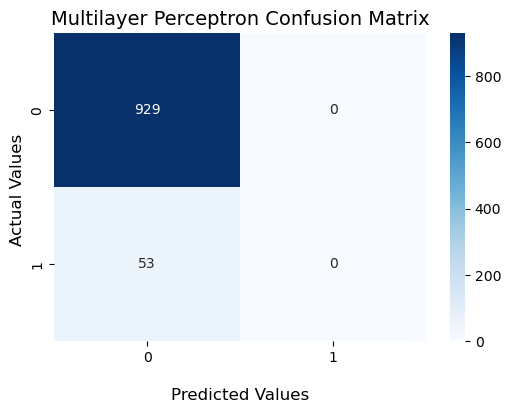

In [51]:
# Confusion matrix for model post feature selection
y_pred = mlp_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Multilayer Perceptron Confusion Matrix", fontsize = 14)
plt.show()

### d) Rerunning *k*-Nearest Neighbors

In [52]:
# Evaluate accuracy for a range of k to pick the optimal value
knn_accuracy = []
possible_k = range(3, 16)
for k in possible_k:
    knn2 = KNeighborsClassifier(n_neighbors = k)
    knn2.fit(X_train2, y_train)
    knn_accuracy.append(knn2.score(X_train2, y_train))

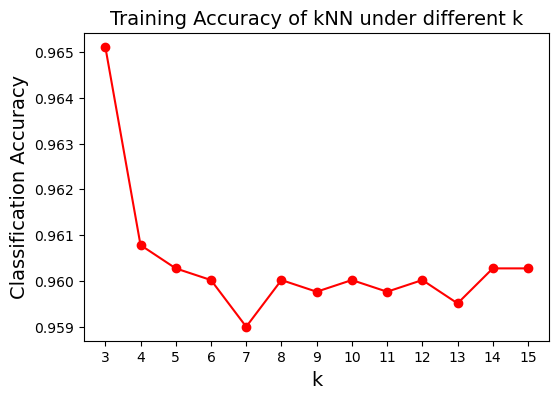

In [53]:
plt.figure(figsize = (6, 4))
plt.plot(possible_k, knn_accuracy, color = 'red', marker = "o")
plt.title("Training Accuracy of kNN under different k", fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_k)
plt.show()

Interestingly, this plot looks exactly like the previous one with the full feature set.

In [54]:
knn2 = KNeighborsClassifier(n_neighbors = 3)
knn2.fit(X_train2, y_train)

print("Training accuracy:", knn2.score(X_train2, y_train))
print("Testing accuracy:", knn2.score(X_test2, y_test))

Training accuracy: 0.9651133180544945
Testing accuracy: 0.9338085539714868


Comparing these accuracies to those from the model for the full feature set (below), the model has slightly better training accuracy but slightly worse testing accuracy after performing feature selection. The difference is very marginal, however.

In [55]:
print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

Training accuracy: 0.964349376114082
Testing accuracy: 0.9348268839103869


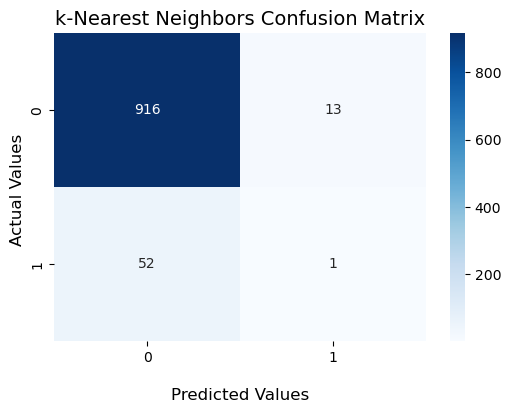

In [56]:
# Confusion matrix for model post feature selection
y_pred = knn2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 14)
plt.show()

### e) Rerunning Decision Trees

In [57]:
# Obtain the accuracy and bias/variance for each Decision Tree to select the best depth
tree_accuracy = []
biases = []
variances = []
possible_depth = range(2, 21)
for d in possible_depth:
    tree_model2 = DecisionTreeClassifier(max_depth = d, random_state = 42)
    tree_model2.fit(X_train2, y_train)
    tree_accuracy.append(tree_model2.score(X_train2, y_train))

    _, bias, var = bias_variance_decomp(tree_model2,
        X_train2.values, y_train.values, X_test2.values, y_test.values, loss = 'mse', random_seed = 123)
    biases.append(bias)
    variances.append(var)

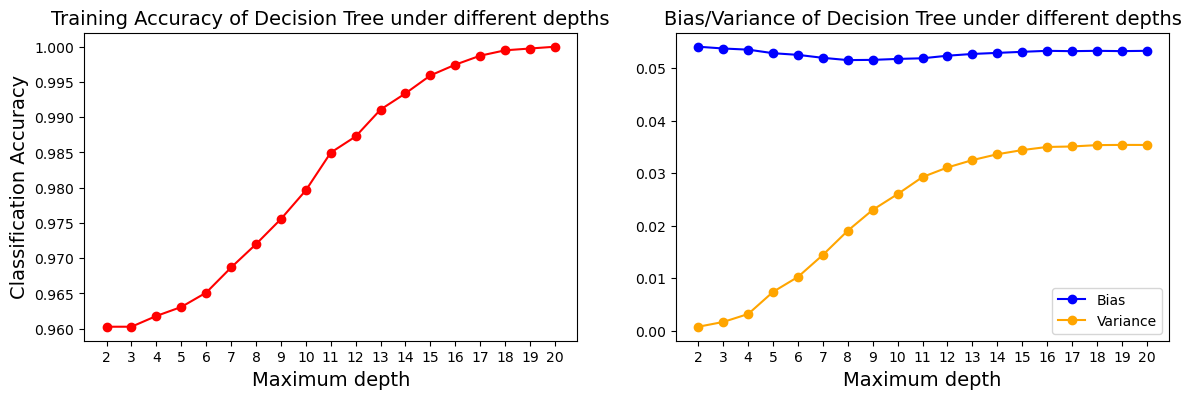

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
ax1.set_title("Training Accuracy of Decision Tree under different depths", fontsize = 14)
ax1.set_xlabel('Maximum depth', fontsize = 14)
ax1.set_ylabel('Classification Accuracy', fontsize = 14)
ax1.set_xticks(possible_depth)

ax2.plot(possible_depth, biases, color = 'blue', marker = "o", label = "Bias")
ax2.plot(possible_depth, variances, color = 'orange', marker = "o", label = "Variance")
ax2.set_title("Bias/Variance of Decision Tree under different depths", fontsize = 14)
ax2.set_xlabel('Maximum depth', fontsize = 14)
ax2.set_xticks(possible_depth)
ax2.legend(loc = "lower right")
plt.show()

Interestingly, these plots looks exactly like the previous ones with the full feature set. I will train the decision tree with `max_depth=7`.

In [59]:
tree_model2 = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_model2.fit(X_train2, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", tree_model2.score(X_train2, y_train))
print("Testing accuracy:", tree_model2.score(X_test2, y_test))

Training accuracy: 0.9686783804430863
Testing accuracy: 0.9409368635437881


Comparing these accuracies to those from the model for the full feature set (below), the model has slightly worse training accuracy after performing feature selection, but there is an increase in testing accuracy by 4%! I'd say the Decision Tree with a maximum depth of 7 does better following feature selection.

In [60]:
print("Training accuracy:", tree_model.score(X_train, y_train))
print("Testing accuracy:", tree_model.score(X_test, y_test))

Training accuracy: 0.9730073847720907
Testing accuracy: 0.9022403258655805


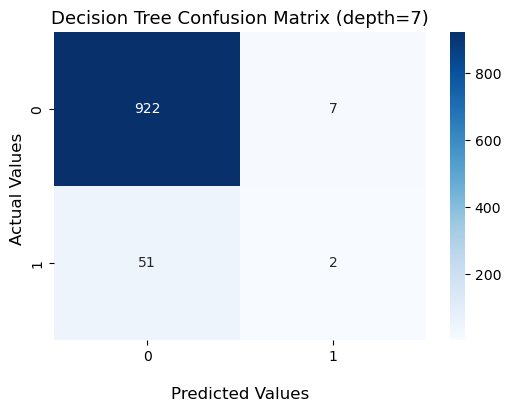

In [61]:
# Confusion matrix for model post feature selection
y_pred = tree_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=7)", fontsize = 13)
plt.show()

### f) Rerunning Random Forest

In [62]:
forest_model2 = RandomForestClassifier(
    max_depth = 7, n_estimators = 500, bootstrap = True, n_jobs = -1, random_state = 42)
forest_model2.fit(X_train2, y_train)
#forest_y_pred = forest_clf.predict(X_test)
#print(f"Forest Classification Report")
#print(classification_report(y_test, forest_y_pred), "\n")

print("Training accuracy:", forest_model2.score(X_train2, y_train))
print("Testing accuracy:", forest_model2.score(X_test2, y_test))

Training accuracy: 0.9618029029793735
Testing accuracy: 0.9460285132382892


Comparing these accuracies to those from the model for the full feature set (below), the model has a slightly worse training accuracy following feature selecting, but the same testing accuracy.

In [63]:
print("Training accuracy:", forest_model.score(X_train, y_train))
print("Testing accuracy:", forest_model.score(X_test, y_test))

Training accuracy: 0.962821492233257
Testing accuracy: 0.9460285132382892


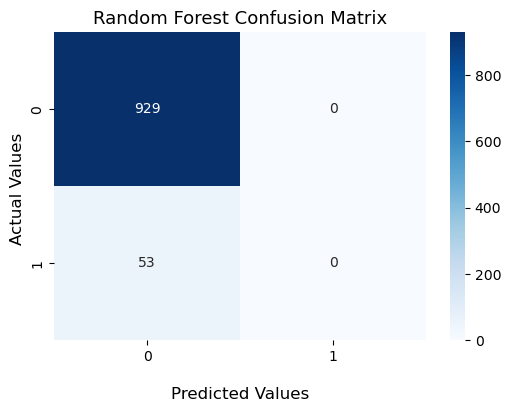

In [64]:
# Confusion matrix for model post feature selection
y_pred = forest_model2.predict(X_test2)
plot_confusion_matrix(y_test, y_pred)
plt.title("Random Forest Confusion Matrix", fontsize = 13)
plt.show()

## Conclusion

All of these models were run, and now the question arises - which is the best binary classifier for this data? Below, I will summarize the results and provide my final decision with reasoning.

### For all variables

Recall that blindly guessing 0 has a training accuracy of 96.03% and testing accuracy of 94.60%. Ideally the best model will have a high accuracy (mostly testing accuracy, since training accuracy is optimized to start with) and also hopefully surpass this metric.

| Model       | Training Accuracy | Testing Accuracy | False Positives | False Negatives|
| ----------- | ----------------- | ---------------- | --------------- | -------------- |
| Blindly Guessing 0 | 96.03% | 94.60% | 53 | 0 |
| Perceptron | 94.98% | 94.40% | 48 | 7 |
| Logistic Regression | 96.05% | 94.60% | 53 | 0 |
| Multilayer Perceptron | 96.03% | 94.60% | 53 | 0 |
| kNN $(k=3)$ | 96.43% | 93.48% | 51 | 13 |
| Decision Tree (`max_depth=7`) | 97.07% | 93.67% | 51 | 11 |
| Random Forests | 96.28% | 94.60% | 53 | 0 |
| Voting (Perceptron, Tree, RF) | 96.28% | 94.50% | 53 | 1 |


No models surpass the testing accuracy of 94.60% from just blindly guessing 0, but the logistic regression, multilayer perceptron, and random forest model all have the same testing accuracy of 94.60%. These three models have similar training accuracies too, within 0.3% of each other at the maximum.

The Perceptron has a testing accuracy of 94.40%, but it has 7 false negative cases, or type II errors. This is a problem because it means that for this data, it will predict that someone doesn't have a stroke when they do, which is dangerous. For this reason, I would not recommend the kNN or Decision Tree either.

Between logistic regression, multilayer perceptron, and random forest model, it's hard to argue based on the table above which one is truly the best. If I had to choose, I would pick the random forest model because of its better properties. One issue with this dataset is that it is unbalanced; there are many more 0's than 1's for the `stroke` variable. Ensemble methods are able to address this issue better than a simpler model like logistic regression, for example.

### For age, avg_glucose_level, bmi only (feature selection)

Next, what is the best model when using the subsetted feature vector to train the model?

| Model       | Training Accuracy | Testing Accuracy | False Positives | False Negatives|
| ----------- | ----------------- | ---------------- | --------------- | -------------- |
| Blindly Guessing 0 | 96.03% | 94.60% | 53 | 0 |
| Perceptron | 95.82% | 94.60% | 52 | 1 |
| Logistic Regression | 96.03% | 94.60% | 53 | 0 |
| Multilayer Perceptron | 96.03% | 94.60% | 53 | 0 |
| kNN $(k=3)$ | 96.51% | 93.38% | 52 | 13 |
| Decision Tree (`max_depth=7`) | 96.87% | 94.09% | 51 | 7 |
| Random Forests | 96.28% | 94.60% | 53 | 0 |

The results are actually similar to the previous section. Nothing surpasses the accuracy of blindly guessing 0 still, but some models improve in performance compared to previously. For example, the decision tree improved in testing accuracy by 0.42% while also having 4 fewer false negative classifications.

A noteworthy mention is the Perceptron, which has improved in both training and testing accuracy. Furthermore, it only misclassifies one false negative case now. For such a simple model, this is pretty impressive, even if I still would not recommend it compared to random forests.

**In conclusion**, the logistic regression, multilayer perceptron, and random forest model are all good binary classifiers for this dataset, given their performance for both feature sets. However, because of its properties for unbalanced data, I would suggest the **random forest** to lower the risk of dangerous misclassifications.